### CS 484/684 Computational Vision
#### Fall 2019, Yuri Boykov

#### Report any typos / errors to the TA, Towaki Takikawa at tovacinni@gmail.com

# Homework Assignment #4 - Supervised Deep Learning for Segmentation

This assignment will test your understanding of applying deep learning by having you apply (fully supervised) deep learning to semantic segmentation, a well studied problem in computer vision. 

You can get most of the work done using only CPU, however, the use of GPU will be helpful in later parts. Programming and debugging everything upto and including problem 5c should be fine on CPU. You will notice the benefit of GPU mostly in later parts (d-h) of problem 5, but they are mainly implemenmted and test your code written and debugged earlier. If you do not have a GPU readily accesible to you, we recommend that you use Google Colaboratory to get access to a GPU. Once you are satisfied with your code upto and including 5(c), simply upload this Jupyter Notebook to Google Colaboratory to run the tests in later parts of Problem 5.

Proficiency with PyTorch is required. Working through the PyTorch tutorials will make this assignment significantly easier. https://pytorch.org/tutorials/

In [1]:
%matplotlib inline

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = False

In [2]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries used for HW4.
# Detailed installation instructions are here: https://pytorch.org/get-started/locally/
# That web site should help you to select the right 'conda install' command to be run in 'Anaconda Prompt'.
# In particular, select the right version of CUDA. Note that prior to installing PyTorch, you should  
# install the latest driver for your GPU and CUDA (9.2 or 10.1), assuming your GPU supports it. 
# For more information about pytorch refer to 
# https://pytorch.org/docs/stable/nn.functional.html
# https://pytorch.org/docs/stable/data.html.
# and https://pytorch.org/docs/stable/torchvision/transforms.html
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

# We provide our own implementation of torchvision.datasets.voc (containing popular "Pascal" dataset)
# that allows us to easily create single-image datasets
from lib.voc import VOCSegmentation

# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined

In [3]:
# ChainerCV is a library similar to TorchVision, created and maintained by Preferred Networks. 
# Chainer, the base library, inspired and led to the creation of PyTorch! 
# Although Chainer and PyTorch are different, there are some nice functionalities in ChainerCV 
# that are useful, so we include it as an excersice on learning other libraries.
# To install ChainerCV, normally it suffices to run "pip install chainercv" inside "Anaconda Prompt".
# For more detailed installation instructions, see https://chainercv.readthedocs.io/en/stable/install.html
# For other information about ChainerCV library, refer to https://chainercv.readthedocs.io/en/stable/ 
from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [4]:
# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

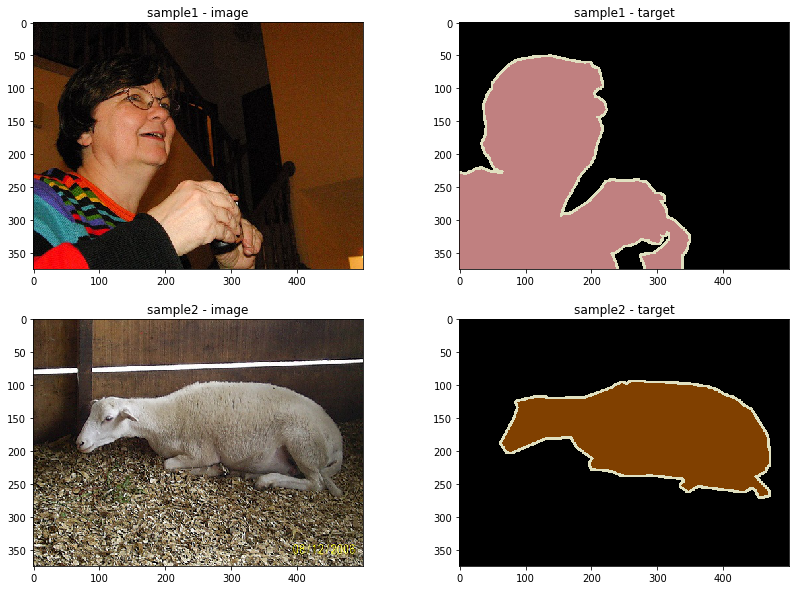

In [5]:
# Below we will use a sample image-target pair from VOC training dataset to test your joint transforms. 
# Running this block will automatically download the PASCAL VOC Dataset (3.7GB) to DATASET_PATH if "download = True".
# The code below creates subdirectory "datasets" in the same location as the notebook file, but
# you can modify DATASET_PATH to download the dataset to any custom directory. Download takes a few minutes.
# On subsequent runs you may save time by setting "download = False" (the default value of this flag)

DATASET_PATH = 'datasets'  

# Here, we obtain and visualize one sample (img, target) pair from VOC training dataset and one from validation dataset. 
# Note that operator [...] extracts the sample corresponding to the specified index. 
# Also, note the parameter download = True. Set this to False after you download to save time on later runs.
sample1 = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[200]
sample2 = VOCSegmentation(DATASET_PATH, image_set='val')[20]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

# Problem 1 

#### Implement a set of "Joint Transform" functions to perform data augmentation in your dataset. 

Neural networks are typically applied to transformed images. There are several important reasons for this: 

1. The image data should is in certain required format (i.e. consistent spacial resolution to batch). The images should also be normalized and converted to the "tensor" data format expected by pytorch libraries. 

2. Some transforms are used to perform randomized image domain transformations with the purpose of "data augmentation". 

In this exercise, you will implement a set of different transform functions to do both of these things. Note that unlike classification nets, training semantic segmentation networks requires that some of the transforms are applied to both image and the corresponding "target" (Ground Truth segmentation mask). We refer to such transforms and their compositions as "Joint". In general, your Transform classes should take as the input both the image and the target, and return a tuple of the transformed input image and target. Be sure to use critical thinking to determine if you can apply the same transform function to both the input and the output.

For this problem you may use any of the `torchvision.transforms.functional` functions. For inspiration, refer to:
#### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#### https://pytorch.org/docs/stable/torchvision/transforms.html#module-torchvision.transforms.functional

#### Example 1

This class takes a img, target pair, and then transform the pair such that they are in `Torch.Tensor()` format.

#### Solution:

In [6]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long()

In [7]:
# Check the transform by passing the image-target sample.

JointToTensor()(*sample1)

(tensor([[[0.0431, 0.0510, 0.0353,  ..., 0.3137, 0.3725, 0.3490],
          [0.0196, 0.0431, 0.0235,  ..., 0.3294, 0.3569, 0.3294],
          [0.0392, 0.0510, 0.0471,  ..., 0.3412, 0.3765, 0.3608],
          ...,
          [0.9412, 0.9961, 1.0000,  ..., 0.9647, 0.9686, 0.9725],
          [1.0000, 0.9686, 0.9961,  ..., 0.9608, 0.9647, 0.9686],
          [1.0000, 0.9490, 1.0000,  ..., 0.9725, 0.9725, 0.9843]],
 
         [[0.0392, 0.0471, 0.0196,  ..., 0.1176, 0.1765, 0.1647],
          [0.0157, 0.0392, 0.0078,  ..., 0.1294, 0.1608, 0.1333],
          [0.0353, 0.0471, 0.0314,  ..., 0.1294, 0.1765, 0.1608],
          ...,
          [0.0157, 0.0667, 0.0706,  ..., 0.6549, 0.6588, 0.6588],
          [0.0784, 0.0431, 0.0667,  ..., 0.6510, 0.6510, 0.6549],
          [0.0745, 0.0235, 0.0784,  ..., 0.6627, 0.6627, 0.6706]],
 
         [[0.0314, 0.0392, 0.0157,  ..., 0.0118, 0.0706, 0.0549],
          [0.0078, 0.0314, 0.0039,  ..., 0.0235, 0.0549, 0.0275],
          [0.0275, 0.0392, 0.0275,  ...,

#### Example 2: 

This class implements CenterCrop that takes an img, target pair, and then apply a crop about the center of the image such that the output resolution is $\mbox{size} \times \mbox{size}$.

#### Solution:

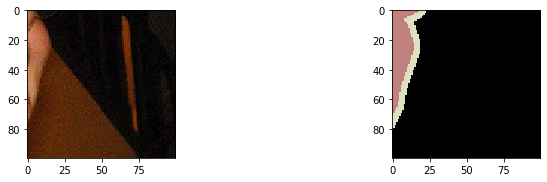

In [8]:
class JointCenterCrop(object):
    def __init__(self, size):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        
    def __call__(self, img, target):
        return (tF.five_crop(img, self.size)[4], 
                tF.five_crop(target, self.size)[4])
    
img, target = JointCenterCrop(100)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### (a) Implement RandomFlip

This class should take a img, target pair and then apply a horizontal flip across the vertical axis at random.

#### Solution:

In [9]:
class JointRandomFlip(object):
    def __call__(self, img, target):
        # 50% chance of conducting hirizontal flip
        if (random.random() > 0.5):
            image = tF.hflip(img)
            target = tF.hflip(target)
        return img, target
    
# Check the transform by passing the image-target sample.
JointRandomFlip()(*sample1)

(<PIL.Image.Image image mode=RGB size=500x375 at 0x22503048F08>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=500x375 at 0x225049BAA08>)

#### (b) Implement RandomResizeCrop

This class should take a img, target pair and then resize the images by a random scale between $[\mbox{minimum_scale}, \mbox{maximum_scale}]$, crop a random location of the image by $\min(\mbox{size}, \mbox{image_height}, \mbox{image_width})$ (where the size is passed in as an integer in the constructor), and then resize to $\mbox{size} \times \mbox{size}$ (again, the size passed in). The crop box should fit within the image.

#### Solution:

In [10]:
class JointRandomResizeCrop(object):
    def __init__(self, size, minimum, maximum):
        """
        params:
            size (int) : size of the resulted image
            minimum (float) : minimum_scale
            maximum (float) : maximum_scale
        """
        self.size = size
        self.scale = random.uniform(minimum,maximum)
        
    def __call__(self,img,target):
        #print(np.shape(img))
        img = tF.resize(img,[math.trunc(np.shape(img)[0]*self.scale),math.trunc(np.shape(img)[1]*self.scale)])
        #print(np.shape(target))
        target = tF.resize(target,[math.trunc(np.shape(target)[0]*self.scale),math.trunc(np.shape(target)[1]*self.scale)])
        top = math.trunc(random.uniform(0,(np.shape(img)[0]-1)))
        left = math.trunc(random.uniform(0,(np.shape(img)[1]-1)))
        crop_size = self.size
        if (crop_size>np.shape(img)[0]):
            crop_size = np.shape(img)[0]
            top = 0
        if (crop_size>np.shape(img)[1]):
            crop_size = np.shape(img)[1]
            left = 0
        return (tF.resized_crop(img,top,left,crop_size,crop_size,self.size),tF.resized_crop(target,top,left,crop_size,crop_size,self.size))

#img, target = JointRandomResizeCrop(10,0.1,2.1)(*sample1)
#fig = plt.figure(figsize=(12,6))
#ax1 = fig.add_subplot(2,3,1)
#ax1.imshow(img)
#ax2 = fig.add_subplot(2,3,2)
#ax2.imshow(target)

#### (c) Implement Normalize

This class should take a img, target pair and then normalize the images by subtracting the mean and dividing variance. 

#### Solution:

In [11]:
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]) 

# square root of variance is the standard deviation
# the class takes in both input img and target as Tensor but only normalize img. target stay the same
class JointNormalize(object):
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def __call__(self, img, target):
        #img_t,target_t = JointToTensor()(img,target)
        # we assume img is Tensor already
        img_normalized = tF.normalize(img,self.mean,np.sqrt(self.variance))
        #target_t_normalized = tF.normalize(target_t,norm[0],np.sqrt(norm[1]))
        return img_normalized, target

# Check the transform by passing the image-target sample.
#JointNormalize(*norm)(*JointToTensor()(*sample1))

#### (d) Compose the transforms together: 
##### Use `JointCompose` (fully implemeted below) to compose the implemented transforms together in some random order. Verify the output makes sense and visualize it.

In [12]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. This cell is fully implemented.

class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


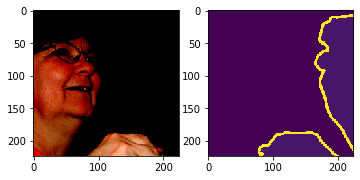

In [13]:
# Student Answer:
# We randomly flip, randomly resize the image, and randomly crop with dimention of min[100,image_width, image_height], and finally make the image into tensor and normalize it.
transform = [JointRandomFlip(),JointRandomResizeCrop(224,0.1,2.1),JointToTensor(),JointNormalize(*norm)]
img, target = JointCompose(transform)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(img.permute(1, 2, 0))
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(target)


#### (e) Compose the transforms together: use `JointCompose` to compose the implemented transforms for:
#### 1. A sanity dataset that will contain 1 single image. Your objective is to overfit on this 1 image, so choose your transforms and parameters accordingly.
#### 2. A training dataset that will contain the training images. The goal here is to generalize to the validation set, which is unseen.
#### 3. A validation dataset that will contain the validation images. The goal here is to measure the 'true' performance.

In [14]:
# Student Answer:

sanity_joint_transform = JointCompose([JointToTensor(),JointNormalize(*norm)])

train_joint_transform = JointCompose([JointRandomFlip(),JointRandomResizeCrop(224,1,2),JointToTensor(),JointNormalize(*norm)])

val_joint_transform = JointCompose([JointToTensor(),JointNormalize(*norm)])



This code below will then apply `train_joint_transform` to the entire dataset.

In [15]:
# Apply the Joint-Compose transformations above to create three datasets and the corresponding Data-Loaders.
# This cell is fully implemented.

# This single image data(sub)set can help to better understand and to debug the network training process. 
# Optional integer parameter 'sanity_check' specifies the index of the image-target pair and creates a single image dataset.
# Note that we use the same image (index=200) as used for sample1.
sanity_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = sanity_joint_transform,
    sanity_check = 200
)

# This is a standard VOC data(sub)set used for training semantic segmentation networks
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = train_joint_transform
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = val_joint_transform
)

# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 4

# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS = 0

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

# Problem 2

#### (a) Implement encoder/decoder segmentation CNN using PyTorch.

You must follow the general network architecture specified in the image below. Note that since convolutional layers are the main building blocks in common network architectures for image analysis, the corresponding blocks are typically unlabeled in the network diagrams. The network should have 5 (pre-trained) convolutional layers from "resnet" in the encoder part, two upsampling layers, and one skip connection. For the layer before the final upsampling layer, lightly experiment with some combination of Conv, ReLU, BatchNorm, and/or other layers to see how it affects performance.   
<img src="images\deeplabv2_overview.png"> 
You should choose specific parameters for all layers, but the overall structure should be restricted to what is shown in the illustration above. For inspiration, you can refer to papers in the citation section of the following link to DeepLab (e.g. specific parameters for each layer): http://liangchiehchen.com/projects/DeepLab.html. The first two papers in the citation section are particularly relevant. 

In your implementation, you can use a base model of choice (you can use `torchvision.models` as a starting point), but we suggest that you learn the properties of each base model and choose one according to the computational resources available to you.

##### Note: do not apply any post-processing (such as DenseCRF) to the output of your net.

#### Solution:


In [16]:
import torchvision.models as models

# The pretrained model of resnet34 
resnet = models.resnet34(pretrained=True)
#print(resnet)

class MyNet(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(MyNet, self).__init__()
        
        # Implement me
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.conv2 = nn.Conv2d((64+512),math.floor(num_classes/2),kernel_size=(3, 3),stride=(2, 2),padding=(1, 1),bias=False)
        self.bn2 = nn.BatchNorm2d(math.floor(num_classes/2), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(math.floor(num_classes/2),num_classes,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
        self.bn3 = nn.BatchNorm2d(num_classes, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.criterion = criterion
    
    def forward(self, inp, gts=None):

        # Implement me
        H = inp.size()[2]
        W = inp.size()[3]
        inp = self.conv1(inp)
        #print(inp.size())
        inp = self.bn1(inp)
        #print(inp.size())
        minp = self.maxpool(inp)
        #print(minp.size())
        inp1 = self.layer1(minp)
        #print(inp1.size())
        #inp2 = self.layer2(inp1+minp)
        inp2 = self.layer2(inp1)
        #print(inp2.size())
        #inp3 = self.layer3(inp2+self.layer2[0].downsample(inp1))
        inp3 = self.layer3(inp2)
        #print(inp3.size())
        #inp4 = self.layer4(inp3+self.layer3[0].downsample(inp2))
        inp4 = self.layer4(inp3)
        #print(inp4.size())
        # Resize the input to match with the output of layer one
        inp = F.interpolate(inp4,size=(inp1.size()[2],inp1.size()[3]))
        #print(inp.size())
        #print(inp1.size())
        inp = torch.cat((inp,inp1),1)
        #print(inp.size())
        # decoder
        inp = self.conv2(inp)
        inp = F.relu(self.bn2(inp))
        inp = self.conv3(inp)
        lfinal = F.relu(self.bn3(inp))
        lfinal = F.interpolate(lfinal,size=(H,W))
        #print(lfinal.size())
        

        if self.training:
            # Return the loss if in training mode
            #print(lfinal.size())
            #print(gts.size())
            return self.criterion(lfinal, gts)              
        else:
            # Return the actual prediction otherwise
            return lfinal


#my_net = MyNet(21)
#print(my_net)

#### (b) Create UNTRAINED_NET and run on a sample image

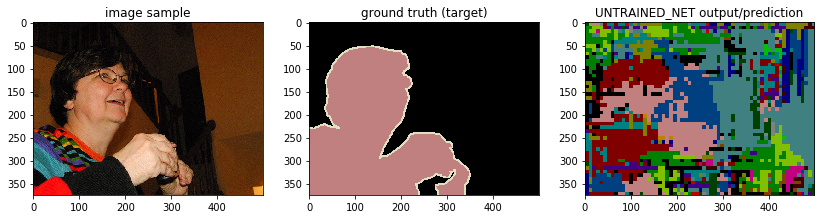

In [17]:
untrained_net = MyNet(21).eval()
#sample_img, sample_target = JointCenterCrop(224)(*sample1)
#sample1 = (sample_img,sample_target)
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
untrained_output = untrained_net.forward(sample_img[None])

#print(sample_img.size())
#print(sample_target.size())
#print(untrained_output.size())
#print(torch.argmax(untrained_output, dim=1).numpy())
#print((torch.argmax(untrained_output, dim=1).numpy()).shape)
#a = np.reshape((torch.argmax(untrained_output, dim=1).numpy()),(224,224))
#print(a)
#print(a.shape)
#print(sample_target.numpy())
#print((sample_target.numpy()).shape)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,3,1)
plt.title('image sample')
ax.imshow(sample1[0])
ax = fig.add_subplot(1,3,2)
plt.title('ground truth (target)')
ax.imshow(sample1[1])
ax = fig.add_subplot(1,3,3)
plt.title('UNTRAINED_NET output/prediction')
ax.imshow(colorize_mask(torch.argmax(untrained_output, dim=1).numpy()[0]))

# Problem 3 

#### (a) Implement the loss function (Cross Entropy Loss). Do not use already implemented versions of this loss function.

Feel free to use functions like `F.log_softmax` and `F.nll_loss` (if you want to, or you can just implement the math).


In [18]:
# Student Answer:

class MyCrossEntropyLoss():
    def __init__(self,ignore_index=-100):
        super(MyCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index

    def __call__(self,inp,target):  
        return F.nll_loss(F.log_softmax(inp,1),target,ignore_index=self.ignore_index)

#### (b) Compare against the existing CrossEntropyLoss function on your sample output from your neural network.

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=255)

print(criterion(untrained_output, sample_target[None]))

my_criterion = MyCrossEntropyLoss(ignore_index=255)

print(my_criterion(untrained_output, sample_target[None]))
    

tensor(2.9680, grad_fn=<NllLoss2DBackward>)
tensor(2.9680, grad_fn=<NllLoss2DBackward>)


# Problem 4

#### (a) Use standard function `eval_semantic_segmentation` (already imported from chainerCV) to compute "mean intersection over union" for the output of UNTRAINED_NET on sample1 (`untrained_output`) using the target for sample1. Read documentations for function  `eval_semantic_segmentation` to properly set its input parameters.

In [20]:
# Write code to propely compute 'pred' and 'gts' as arguments for function 'eval_semantic_segemntation'
# not done

pred = np.reshape((torch.argmax(untrained_output, dim=1).numpy()),(untrained_output.size()[2],untrained_output.size()[3]))
gts = np.reshape(sample_target.numpy(),(sample_target.size()[0],sample_target.size()[1]))

#print(pred.ndim)
#print(gts.ndim)

conf = eval_semantic_segmentation(pred[None], gts[None])

print("mIoU for the sample image / ground truth pair: {}".format(conf['miou']))

mIoU for the sample image / ground truth pair: 0.012723116696913403


C:\Users\Admin\Anaconda3\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
C:\Users\Admin\Anaconda3\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


#### (b) Write the validation loop.

In [21]:
def validate(val_loader, net):
    
    iou_arr = []
    
    val_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
        
            inputs, masks = data
            H = inputs.size()[2]
            W = inputs.size()[3]

            if USE_GPU:
                # Write me
                inputs = inputs.cuda()
                masks = masks.cuda()
                net = net.cuda()
            #else: 
                # Write me
            
            #print(inputs.size())
            #print(masks.size())
            
            # Write me
            output = net(inputs)
            
            #print(output.size())
            #print(masks.size())
            #print(H)
            #print(W)
            #print(masks)
            
            #al_loss += F.nll_loss(output, masks, reduction='sum').item()
            val_loss += F.cross_entropy(output,masks,ignore_index=255).item()
            #val_loss += criterion(output,masks).item()

            # Hint: make sure the range of values of the ground truth is what you expect
            if USE_GPU:
                gts = np.reshape(masks.cpu().numpy(),(H,W))
                preds = np.reshape(torch.argmax(output, dim=1).cpu().numpy(),(H,W))
            else:
                gts = np.reshape(masks.numpy(),(H,W))
                preds = np.reshape(torch.argmax(output, dim=1).numpy(),(H,W))
                
            gts == np.where(gts==255,-1,gts)
            
            #print(preds.shape)
            #print(gts.shape)

            conf = eval_semantic_segmentation(preds[None], gts[None])

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

#### (c) Run the validation loop for UNTRAINED_NET against the sanity validation dataset.

In [22]:
%%time
print("mIoU over the sanity dataset:{}".format(validate(sanity_loader, untrained_net)[1]))

mIoU over the sanity dataset:0.012723116696913403
Wall time: 1.92 s


# Problem 5

#### (a) Define an optimizer to train the given loss function.

Feel free to choose your optimizer of choice from https://pytorch.org/docs/stable/optim.html.


In [23]:
import torch.optim as optim

def get_optimizer(net):
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    return optimizer




#### (b) Write the training loop to train the network. 


In [24]:
def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, masks = data

        if USE_GPU:
            # Write me
            inputs = inputs.cuda()
            net = net.cuda()
            masks = masks.cuda()
        
        # Write me
        optimizer.zero_grad()
        main_loss = net(inputs, gts=masks)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()
        
        # loss_graph.append() Populate this list to graph the loss
        
    return main_loss

#### (c) Create OVERFIT_NET and train it on the single image dataset.
##### Single image training is helpful for debugging and hyper-parameter tuning (e.g. learning rate, etc.) as it is fast even on a single CPU. In particular, you can work with a single image until your loss function is consistently decreasing during training loop and the network starts producing a reasonable output for this training image. Training on a single image also teaches about overfitting, particualrly when comparing it with more thorough forms of network training. 

Starting Training...


<IPython.core.display.Javascript object>


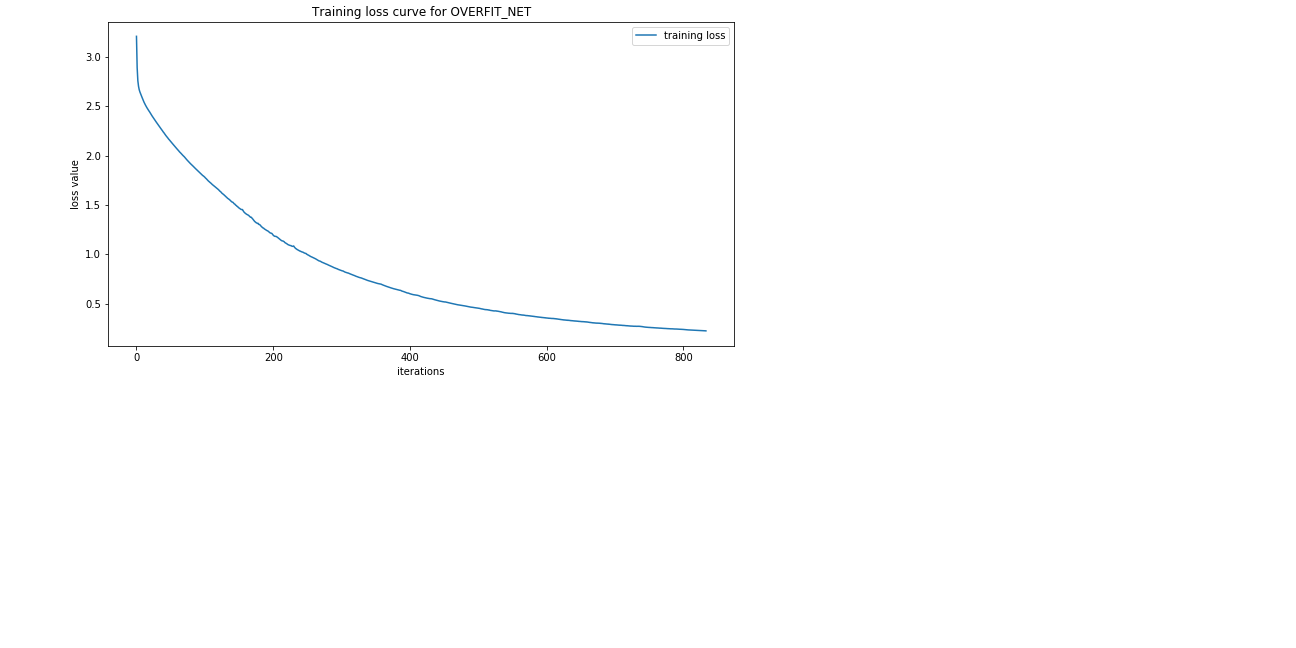

Epoch: 0 Loss: 3.210134267807007
Epoch: 1 Loss: 2.8927578926086426
Epoch: 2 Loss: 2.760532855987549
Epoch: 3 Loss: 2.7036895751953125
Epoch: 4 Loss: 2.6689367294311523
Epoch: 5 Loss: 2.6461963653564453
Epoch: 6 Loss: 2.6275787353515625
Epoch: 7 Loss: 2.611337423324585
Epoch: 8 Loss: 2.5932116508483887
Epoch: 9 Loss: 2.575467348098755
Epoch: 10 Loss: 2.557943820953369
Epoch: 11 Loss: 2.542593240737915
Epoch: 12 Loss: 2.527724504470825
Epoch: 13 Loss: 2.5145905017852783
Epoch: 14 Loss: 2.501408576965332
Epoch: 15 Loss: 2.489309310913086
Epoch: 16 Loss: 2.4776315689086914
Epoch: 17 Loss: 2.467034101486206
Epoch: 18 Loss: 2.455744743347168
Epoch: 19 Loss: 2.4461212158203125
Epoch: 20 Loss: 2.4344429969787598
Epoch: 21 Loss: 2.423731803894043
Epoch: 22 Loss: 2.411510467529297
Epoch: 23 Loss: 2.400905132293701
Epoch: 24 Loss: 2.3904294967651367
Epoch: 25 Loss: 2.3792366981506348
Epoch: 26 Loss: 2.368499517440796
Epoch: 27 Loss: 2.3586151599884033
Epoch: 28 Loss: 2.348994016647339
Epoch: 29 L

Epoch: 233 Loss: 1.0571882724761963
Epoch: 234 Loss: 1.0536640882492065
Epoch: 235 Loss: 1.047391653060913
Epoch: 236 Loss: 1.0445817708969116
Epoch: 237 Loss: 1.039384126663208
Epoch: 238 Loss: 1.036487340927124
Epoch: 239 Loss: 1.031793475151062
Epoch: 240 Loss: 1.0308122634887695
Epoch: 241 Loss: 1.0257253646850586
Epoch: 242 Loss: 1.023821234703064
Epoch: 243 Loss: 1.0214595794677734
Epoch: 244 Loss: 1.0191856622695923
Epoch: 245 Loss: 1.014119029045105
Epoch: 246 Loss: 1.0111302137374878
Epoch: 247 Loss: 1.0087662935256958
Epoch: 248 Loss: 1.007554531097412
Epoch: 249 Loss: 1.0001932382583618
Epoch: 250 Loss: 0.9966602921485901
Epoch: 251 Loss: 0.9918404817581177
Epoch: 252 Loss: 0.9896770715713501
Epoch: 253 Loss: 0.9837084412574768
Epoch: 254 Loss: 0.9805781245231628
Epoch: 255 Loss: 0.9761949777603149
Epoch: 256 Loss: 0.973516583442688
Epoch: 257 Loss: 0.9701903462409973
Epoch: 258 Loss: 0.9669143557548523
Epoch: 259 Loss: 0.9626559615135193
Epoch: 260 Loss: 0.9597387909889221


Epoch: 462 Loss: 0.4987970292568207
Epoch: 463 Loss: 0.49766305088996887
Epoch: 464 Loss: 0.4963095486164093
Epoch: 465 Loss: 0.49463632702827454
Epoch: 466 Loss: 0.49276793003082275
Epoch: 467 Loss: 0.4914749562740326
Epoch: 468 Loss: 0.4901963770389557
Epoch: 469 Loss: 0.4886471629142761
Epoch: 470 Loss: 0.48706477880477905
Epoch: 471 Loss: 0.4863715171813965
Epoch: 472 Loss: 0.48573464155197144
Epoch: 473 Loss: 0.4839668273925781
Epoch: 474 Loss: 0.4829344153404236
Epoch: 475 Loss: 0.4817972779273987
Epoch: 476 Loss: 0.4811467230319977
Epoch: 477 Loss: 0.4802277088165283
Epoch: 478 Loss: 0.47949934005737305
Epoch: 479 Loss: 0.4781283140182495
Epoch: 480 Loss: 0.4762919247150421
Epoch: 481 Loss: 0.4747235178947449
Epoch: 482 Loss: 0.4732542634010315
Epoch: 483 Loss: 0.4718007743358612
Epoch: 484 Loss: 0.47066470980644226
Epoch: 485 Loss: 0.46897241473197937
Epoch: 486 Loss: 0.4675769507884979
Epoch: 487 Loss: 0.4659578800201416
Epoch: 488 Loss: 0.4647877514362335
Epoch: 489 Loss: 0.4

Epoch: 688 Loss: 0.2927525043487549
Epoch: 689 Loss: 0.29064229130744934
Epoch: 690 Loss: 0.2918650209903717
Epoch: 691 Loss: 0.28928515315055847
Epoch: 692 Loss: 0.2902616858482361
Epoch: 693 Loss: 0.287824809551239
Epoch: 694 Loss: 0.28853046894073486
Epoch: 695 Loss: 0.2862090468406677
Epoch: 696 Loss: 0.2868942618370056
Epoch: 697 Loss: 0.2850092947483063
Epoch: 698 Loss: 0.2858524024486542
Epoch: 699 Loss: 0.2838573157787323
Epoch: 700 Loss: 0.28469762206077576
Epoch: 701 Loss: 0.282755047082901
Epoch: 702 Loss: 0.2836640477180481
Epoch: 703 Loss: 0.2815847098827362
Epoch: 704 Loss: 0.28260356187820435
Epoch: 705 Loss: 0.28047463297843933
Epoch: 706 Loss: 0.28148964047431946
Epoch: 707 Loss: 0.27945253252983093
Epoch: 708 Loss: 0.28052619099617004
Epoch: 709 Loss: 0.27883946895599365
Epoch: 710 Loss: 0.2795652747154236
Epoch: 711 Loss: 0.27743613719940186
Epoch: 712 Loss: 0.2783432602882385
Epoch: 713 Loss: 0.2765997052192688
Epoch: 714 Loss: 0.27727559208869934
Epoch: 715 Loss: 0

In [25]:
%%time
%matplotlib notebook

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU). 
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets 
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training. 
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net. 
overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
overfit_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# You can change the number of EPOCHS
EPOCH = 834

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

#### Qualitative and quantitative evaluation of predictions (untrained vs overfit nets) - fully implemented.

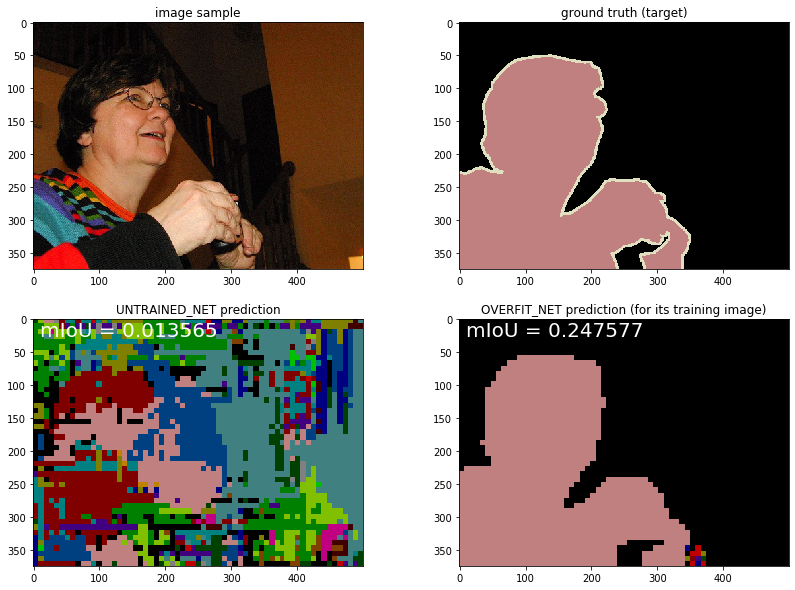

In [26]:
# switch back to evaluation mode
overfit_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for its training image)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

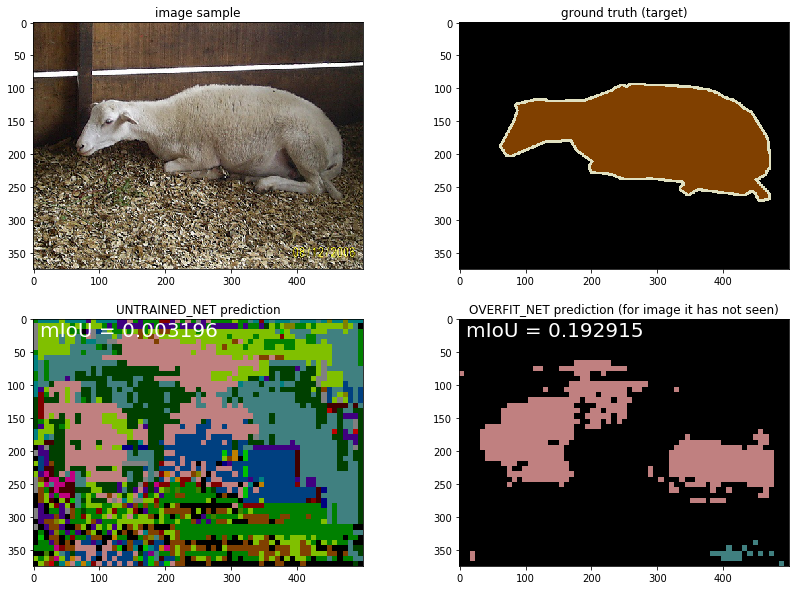

In [27]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

#### Run the validation loop for OVERFIT_NET against the sanity dataset (an image it was trained on) - fully implemented

In [28]:
%%time
print("mIoU for OVERFIT_NET over its training image:{}".format(validate(sanity_loader, overfit_net)[1]))

mIoU for OVERFIT_NET over its training image:0.21336155397837425
Wall time: 4.9 s


### WARNING: For the remaining part of the assignment (below) it is advisable to switch to GPU mode as running each validation and training loop on the whole training set takes over an hour on CPU (there are several such loops below). Note that GPU mode is helpful only if you have a sufficiently good NVIDIA gpu (not older than 2-3 years) and cuda installed on your computer. If you do not have a sufficiently good graphics card available, you can still finish the remaining part in CPU mode (takes a few hours), as the cells below are mostly implemented and test your code written and debugged in the earlier parts above. You can also switch to Google Colaboratory to run the remaining parts below.

### You can use validation-data experiments below to tune your hyper-parameters. Normally, validation data is used exactly for this purpose. For actual competitions, testing data is not public and you can not tune hyper-parameters on in. 

#### (d) Evaluate UNTRAINED_NET and OVERFIT_NET on validation dataset.
##### Run the validation loop for UNTRAINED_NET against the validation dataset:

In [29]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)[1]))

mIoU for UNTRAINED_NET over the entire dataset:0.004493000502464969
Wall time: 33min 16s


##### Run the validation loop for OVERFIT_NET against the validation dataset (it has not seen): 

In [30]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for OVERFIT_NET over the validation dataset:{}".format(validate(val_loader, overfit_net)[1]))

mIoU for OVERFIT_NET over the validation dataset:0.10165833317899822
Wall time: 33min 19s


#### (e) Explain in a few sentences the quantitative results observed in (c), and (d):

Student answer:

From c), we see that training on single image dataset (the sanity set) with large enough EPO (around 834) create an overfit net that have a fair accuracy on prediction of the input image belong to the sanity data set. In fact, we are able to see the rough segmentatino in the resulted image. However, we also see that it only recognize the label that it have been trained on. Thus, it will try to label image from other dataset to the one belong to the sanity dataset. Furthermore, the overfit net yields the similar result on all sanity data set. It shows that it generalized well into other data in the same dataset. From d), we see that the overfit net have a lower accurary on prediction of validation dataset (image that the network has never seen before). It shows that it don't generalize well into other dataset than the one it have been trained on. However, it still produce higher accuracy than the untrained network. In fact, untrained netwrok show no better result predicting against validation dataset than predicting against sanity dataset. 

#### (f) Create TRAINED_NET and train it on the full training dataset:

Starting Training...


<IPython.core.display.Javascript object>


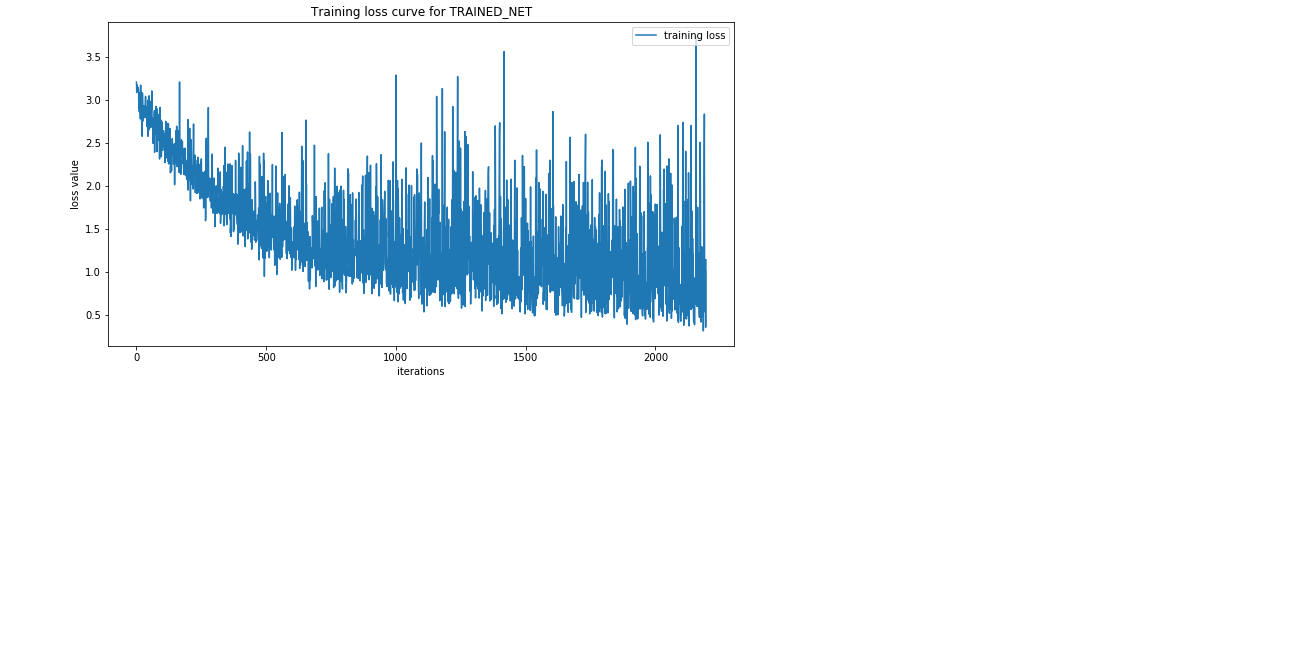

Epoch: 0 Loss: 1.652018666267395
Epoch: 1 Loss: 1.224165439605713
Epoch: 2 Loss: 1.2609058618545532
Epoch: 3 Loss: 1.1289594173431396
Epoch: 4 Loss: 0.7918080687522888
Epoch: 5 Loss: 1.1463441848754883
Wall time: 2h 2min 54s


In [40]:
%%time
%matplotlib notebook

# This training will be very slow on a CPU (>1hour per epoch). Ideally, this should be run in GPU mode (USE_GPU=True) 
# taking only a few minutes per epoch (depending on your GPU and batch size). Thus, before proceeding with this excercise,
# it is highly advisable that you first finish debugging your net code. In particular, make sure that OVERFIT_NET behaves 
# reasonably, e.g. its loss monotonically decreases during training and its output is OK (for the image it was trained on). 
# Below we create another (deep) copy of untrained_net. Unlike OVERFIT_NET it will be trained on a full training dataset.
trained_net = copy.deepcopy(untrained_net)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=255)


# You can change the number of EPOCHS below. Since each epoch for TRAINED_NET iterates over all training dataset images,
# the number of required epochs could be smaller compared to OFERFIT_NET where each epoch iterates over one-image-dataset)
EPOCH = 6

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAINED_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()    
    print("Epoch: {} Loss: {}".format(e, loss))
    
%matplotlib inline

#### (g) Qualitative and quantitative evaluation of predictions (OVERFIT_NET vs TRAINED_NET):

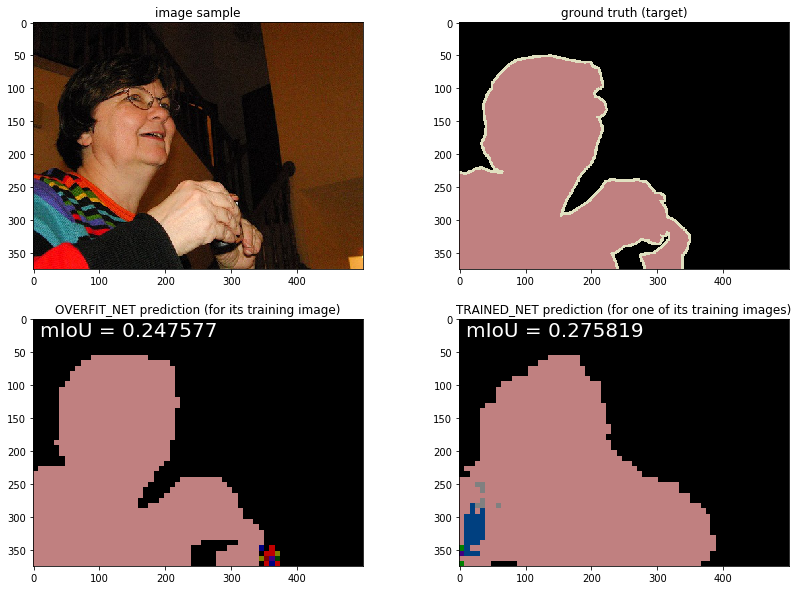

In [41]:
# switch back to evaluation mode
trained_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for its training image)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for one of its training images)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

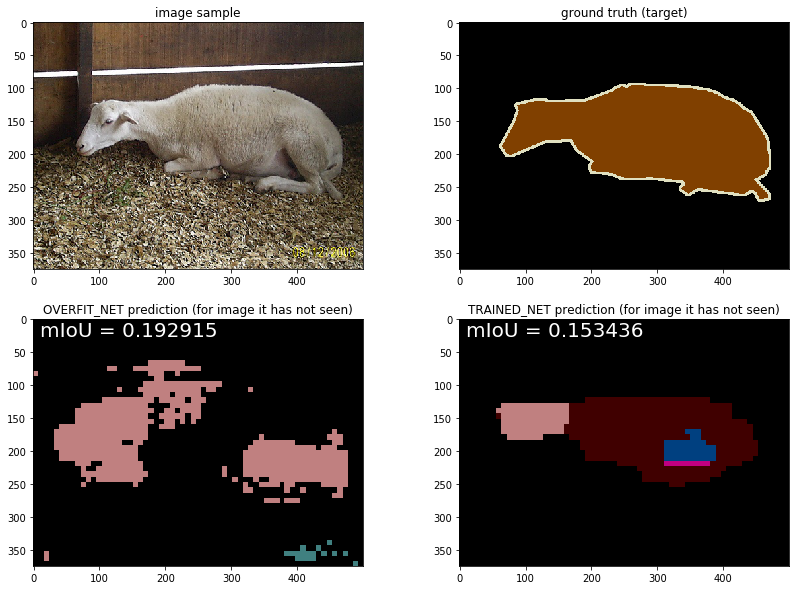

In [42]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

#### (h) Evaluate TRAINED_NET on validation dataset.
##### Run the validation loop for TRAINED_NET against the validation dataset (it has not seen): 

In [43]:
%%time
# This will be slow on CPU (around 1 hour). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for TRAINED_NET over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

mIoU for TRAINED_NET over the validation dataset:0.1995582596151022
Wall time: 35min 3s


# Problem 6

#### For the network that you implemented, write a paragraph or two about limitations / bottlenecks about the work. What could be improved? What seems to be some obvious issues with the existing works?

First, it is obvious that the network are bias toward what it has been trained on. We can see that the mloU of overfit net and mloU of trained net do not change much for the prediction of the sample image1, but the overfit net definitely has a better segmentation. This in general shows that a netweok trained on one image perfrom beeter segmentation on that image than the net trained on other iamge. In contrast, both network also have a similar mloU for the prediction of the sample image2 (for image they have never seen before), but trained net start to identify the image other than human. Thus shows that the netwrok trained on one image can only identify label from that particular image while the network also trained on other images can identify multiple lables from multiple image that it has been trained on. These issues can be addressed by providing larger data set for training and making sure the network has seen all the labels throughout its traning by manually preparing dataset containing all lebel (ideally evenly). Futhermore, we can also see the trained network have hard time distinguish the face of human and animal. This, in contrast with th solution of previous issues of providing training dataset with all labels evenly, we could include image with labels that we want to network to identify more in the training dataset. It will be a trading between aiming for generalization or specialization in identifying labels.  